# Create OSM Polygon CSV

Each table represent polygon of OSM. The columns shall contain the presense of avrora store, different amenities, crafts, healthcare, historic, leisure, offices, public transport, shops, and tourism.

## Connect to PostGIS database

In [1]:
import psycopg2
import geopandas as gpd
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Connect to PostGIS database
db_params = {
    'dbname': 'osm',
    'user': 'postgres',
    'password': 'postpass',  # from Makefile
    'host': 'localhost',
    'port': '5432'
}

# Create SQLAlchemy engine for GeoDataFrames
engine = create_engine(f'postgresql://{db_params["user"]}:{db_params["password"]}@{db_params["host"]}:{db_params["port"]}/{db_params["dbname"]}')


## Exploratory analysis of OSM data

Get distinct amenities count and types

In [3]:
def get_amenity_counts(city=None):
    """
    Get counts of different amenity types, optionally filtered by city.
    
    Parameters:
    -----------
    city : str, optional
        Name of the city to filter by (e.g., 'Київ', 'Львів')
        If None, returns counts for the entire database
    """
    # city filter if specified
    city_filter = ""
    if city:
        city_filter = """
        AND way && (
            SELECT way 
            FROM planet_osm_polygon 
            WHERE name = :city 
            AND boundary = 'administrative'
            LIMIT 1
        )
        AND ST_Contains(
            (SELECT way 
             FROM planet_osm_polygon 
             WHERE name = :city 
             AND boundary = 'administrative'
             LIMIT 1
            ),
            way
        )
        """
    
    query = text(f"""
    SELECT 
        amenity, 
        COUNT(*) as count
    FROM planet_osm_point 
    WHERE amenity IS NOT NULL
        {city_filter}
    GROUP BY amenity
    ORDER BY count DESC;
    """)
    
    params = {'city': city} if city else {}
    df = pd.read_sql_query(query, engine, params=params)
    
    print(f"Number of different amenity types{' in ' + city if city else ''}: {len(df)}")
    return df


In [4]:
kyiv_amenities = get_amenity_counts('Київ')
display("Amenities in Kyiv:", kyiv_amenities)

Number of different amenity types in Київ: 137


'Amenities in Kyiv:'

,amenity,count
0,bench,5253
1,waste_disposal,2333
2,cafe,1890
3,pharmacy,1530
4,atm,1301
...,...,...
132,tourism,1
133,toy_library,1
134,training_center,1
135,watering_place,1


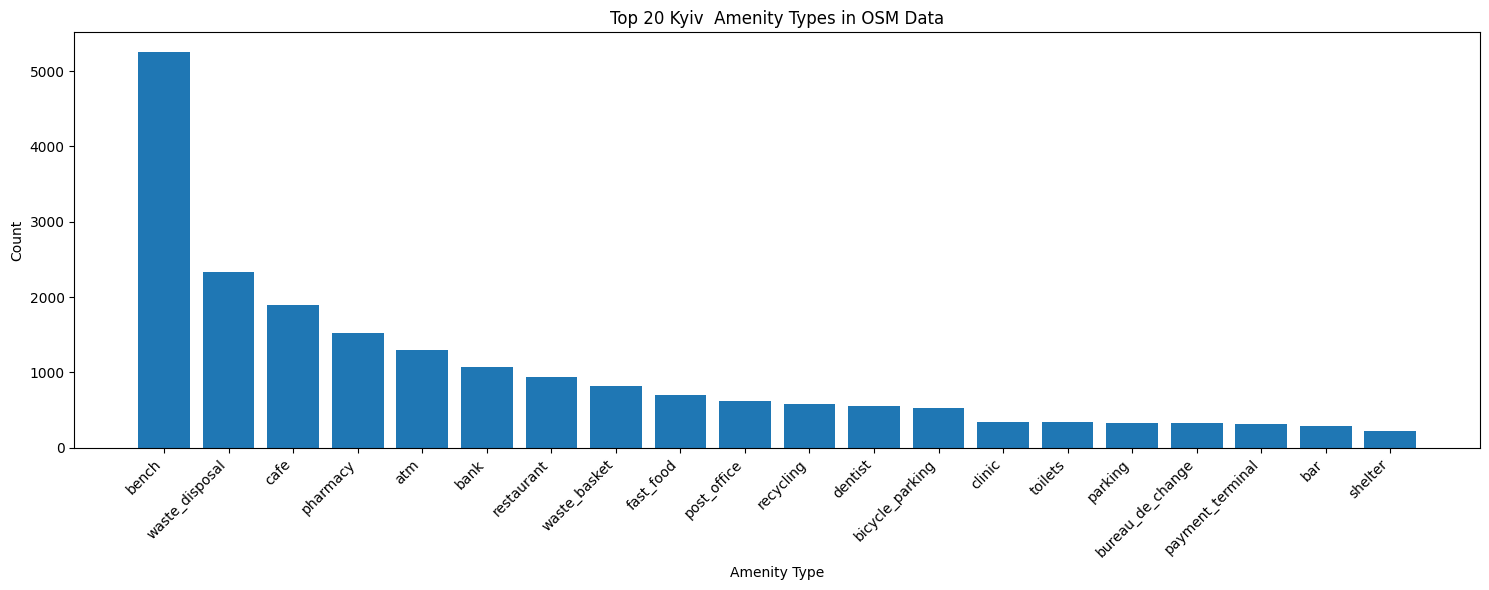

In [5]:
# Plot top 50 amenity types
def plot_amenity_types(amenities, location, num_amenities=20):
    plt.figure(figsize=(15, 6))
    top_amenities = amenities.head(num_amenities)
    plt.bar(top_amenities['amenity'], top_amenities['count'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Top %d %s  Amenity Types in OSM Data' % (num_amenities, location))
    plt.xlabel('Amenity Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

plot_amenity_types(kyiv_amenities, 'Kyiv')


## Analyse amenities top chains/brands of different amenities types

In [6]:
def analyze_chains(place_type, type_value, city_polygon=None, top_n=20, min_locations=1):
    """
    Parameters:
    -----------
    place_type : str
        Either 'amenity' or 'shop'
    type_value : str
        Value of amenity/shop (e.g., 'cafe', 'supermarket', etc.)
    city_polygon : str, optional
        Name of the city to filter by (e.g., 'Київ', 'Львів')
    """
    # Add geographic filter if city is specified
    city_filter = ""
    if city_polygon:
        city_filter = f"""
        AND way && (
            SELECT way 
            FROM planet_osm_polygon 
            WHERE name = '{city_polygon}' 
            AND boundary = 'administrative'
            LIMIT 1
        )
        AND ST_Contains(
            (SELECT way 
             FROM planet_osm_polygon 
             WHERE name = '{city_polygon}' 
             AND boundary = 'administrative'
             LIMIT 1
            ),
            way
        )
        """
    
    query = f"""
    WITH chain_stats AS (
        SELECT 
            name,
            COUNT(*) as locations_count,
            string_agg(DISTINCT brand, ', ') as brands,
            string_agg(DISTINCT operator, ', ') as operators,
            string_agg(DISTINCT tags->'cuisine', ', ') as cuisines,
            COUNT(DISTINCT ST_SnapToGrid(way, 0.0001)) as unique_locations,
            string_agg(DISTINCT tags::text, ' | ') as all_tags,
            MIN(ST_Y(way)) as min_lat,
            MAX(ST_Y(way)) as max_lat,
            MIN(ST_X(way)) as min_lon,
            MAX(ST_X(way)) as max_lon
        FROM planet_osm_point 
        WHERE 
            {place_type} = '{type_value}'
            AND name IS NOT NULL
            {city_filter}
        GROUP BY name
        HAVING COUNT(*) >= {min_locations}
        ORDER BY locations_count DESC
        LIMIT {top_n}
    )
    SELECT 
        name,
        locations_count,
        unique_locations,
        brands,
        operators,
        cuisines,
        all_tags,
        max_lat - min_lat as lat_spread,
        max_lon - min_lon as lon_spread
    FROM chain_stats;
    """
    
    # Use read_sql_query with raw connection to avoid SQLAlchemy issues
    connection = engine.raw_connection()
    cursor = connection.cursor()
    
    try:
        cursor.execute(query)
        columns = [desc[0] for desc in cursor.description]
        data = cursor.fetchall()
        results = pd.DataFrame(data, columns=columns)
    finally:
        cursor.close()
        connection.close()
    
    if len(results) > 0:
        # Add geographic spread
        results['geographic_spread_km'] = np.sqrt(
            (results['lat_spread'] * 111)**2 + 
            (results['lon_spread'] * 111 * np.cos(50.45 * np.pi/180))**2
        )
        results = results.round({'geographic_spread_km': 2})
    
    return results

#### Top cafe chains

In [7]:
# For cafes (amenity)
cafes = analyze_chains('amenity', 'cafe', top_n=20, city_polygon='Київ')
display("Top cafe chains:", cafes)

'Top cafe chains:'

,name,locations_count,unique_locations,brands,operators,cuisines,all_tags,lat_spread,lon_spread,geographic_spread_km
0,Lviv Croissants,21,21,"Lviv Croissants, Lviv croissants",None,"bakery;coffee_shop, coffee_shop","""cuisine""=>""coffee_shop"", ""name:en""=>""Lviv Cro...",18746.240027,26359.286565,2793000.47
1,Aroma Kava,19,19,Aroma Kava,Aroma Kava,coffee_shop,"""cuisine""=>""coffee_shop"", ""name:en""=>""Aroma Ka...",10472.164579,26602.374937,2210542.84
2,Хлібна кава,17,17,None,None,coffee_shop,"""cuisine""=>""coffee_shop"" | ""cuisine""=>""coffee_...",22286.500840,15502.296628,2705593.74
3,Арома Кава,16,16,Aroma Kava,Aroma kava,coffee_shop,"""atm""=>""yes"", ""cuisine""=>""coffee_shop"", ""name:...",18118.518404,33133.533990,3086915.43
4,AROMA KAVA,16,16,Aroma Kava,Aroma Kava,coffee_shop,"| ""cuisine""=>""coffee_shop"" | ""cuisine""=>""coff...",19733.682274,24871.256668,2808590.97
5,Кав'ярня,8,8,None,None,"coffee_shop, coffee_shop;ice_cream","""cuisine""=>""coffee_shop"", ""name:en""=>""Coffee S...",14279.202252,18709.143991,2064173.01
6,Merry Berry,7,7,None,Меррі-Групп,coffee_shop,"""cuisine""=>""coffee_shop"", ""name:uk""=>""Merry Be...",19360.160767,31053.384589,3071710.37
7,Хлібна Кава,7,7,None,None,coffee_shop,"""cuisine""=>""coffee_shop"", ""name:uk""=>""Хлібна К...",14330.574700,12763.981870,1828710.58
8,Горький,5,5,None,None,coffee_shop,"""cuisine""=>""coffee_shop"", ""name:uk""=>""Горький""...",2550.149340,4177.675774,409040.80
9,Волконський,5,5,None,None,None,"""name:ru""=>""Волконский"", ""name:uk""=>""Волконськ...",22387.153146,17294.874388,2769356.67


#### Top shop and supermarket chains

In [8]:
# For supermarkets (shop)
supermarkets = analyze_chains('shop', 'supermarket', top_n=40, city_polygon='Київ')
display("Top supermarket chains:", supermarkets)

'Top supermarket chains:'

,name,locations_count,unique_locations,brands,operators,cuisines,all_tags,lat_spread,lon_spread,geographic_spread_km
0,Фора,148,148,Фора,ТОВ «ФОРА»,None,"| ""atm""=>""yes"", ""level""=>""0"", ""name:en""=>""For...",35416.800717,37456.426040,4739573.63
1,АТБ-Маркет,81,81,"АТБ-Маркет, АТБ-маркет","АТБ, АТБ-Маркет",None,"""branch""=>""910"", ""name:en""=>""ATB-Market"", ""nam...",25202.092939,35699.949190,3767283.24
2,Сільпо,76,76,Сільпо,None,None,"""atm""=>""yes"", ""name:en""=>""Silpo"", ""name:uk""=>""...",33646.171781,36579.016945,4542287.57
3,ЛотОК,52,52,ЛотОК,ЛК-ТРАНС,None,"""level""=>""1"", ""name:uk""=>""ЛотОК"", ""phone:UA""=>...",25117.589838,39361.236111,3938644.35
4,АТБ-маркет,41,41,АТБ-маркет,"АТБ, ТОВ ""АТБ-Маркет""",None,"""email""=>""kievpred@atbmarket.com"", ""phone""=>""+...",29339.498289,33448.835316,4024322.01
5,Novus,26,26,"Novus, Новус","NOVUS, Novus",None,"""brand:wikidata""=>""Q116748340"" | ""check_date""=...",22969.554575,31533.672532,3386447.98
6,ЕКО маркет,16,16,ЕКО маркет,"Еко-Маркет, ТОВ «ЕКО»",None,"""addr:street""=>""Прирічна вулиця"", ""brand:wikid...",24140.964572,41555.621573,3975829.45
7,Thrash! Траш!,13,13,Thrash! Траш!,None,None,"""name:en""=>""Thrash!"", ""name:uk""=>""Траш!"", ""bra...",21896.352661,31645.047683,3303017.28
8,Varus,13,13,Varus,"Varus, ОМЕГА",None,"""level""=>""1"", ""name:uk""=>""Varus"", ""phone:UA""=>...",22282.235376,33558.774445,3426853.98
9,Продукти,6,6,None,ФОП Передрiй Г.С.,None,"""name:uk""=>""Продукти"" | ""name:uk""=>""Продукти"",...",23172.894976,11113.013634,2689445.57


#### Top pharmacies chains

In [9]:
# For pharmacies (amenity)
pharmacies = analyze_chains('amenity', 'pharmacy', top_n=20, city_polygon='Київ')
display("Top pharmacy chains:", pharmacies)

'Top pharmacy chains:'

,name,locations_count,unique_locations,brands,operators,cuisines,all_tags,lat_spread,lon_spread,geographic_spread_km
0,АНЦ,88,88,АНЦ,"Ласкава Фарм, ТОВ ""АПТЕКА НИЗЬКИХ ЦІН ТМ""",None,"""dispensing""=>""yes"", ""healthcare""=>""pharmacy"",...",32531.140659,35575.939278,4400187.23
1,Аптека оптових цін,74,74,"АНЦ, Аптека оптових цін, Аптека оптових ц‥","Є Аптека Тов, Аптека №28 ТОВ, ВІТАНІКУС ТОВ, Д...",None,"| ""level""=>""0"", ""name:ru""=>""Аптека оптовых це...",28887.872853,35316.665052,4063595.20
2,Бажаємо здоров'я,69,69,"Бажаємо здоров'я, Бажаємо здоровʼя","ТОВ ""Сіріус-95""",None,"""level""=>""0"", ""name:uk""=>""Бажаємо здоров'я"", ""...",25565.359884,36728.919772,3846031.06
3,Подорожник,68,68,Подорожник,"Ласкава Фарм, Подорожник, Подорожник Київ",None,"""dispensing""=>""no"", ""healthcare""=>""pharmacy"", ...",29080.357237,36791.648305,4145070.06
4,Аптека Доброго Дня,67,67,"Аптека Доброго Дня, Аптека доброго дня","Аптека Доброго Дня, Аптека доброго дня, ТОВ ""А...",None,"""healthcare""=>""pharmacy"", ""brand:wikidata""=>""Q...",26625.545844,30872.301173,3673673.82
5,Фармація,54,54,None,"КП ""Фармація"", Комунальне підприємство ""Фармац...",None,"""healthcare""=>""pharmacy"", ""opening_hours""=>""Mo...",27012.011098,37649.609884,4008889.99
6,Аптека доброго дня,46,46,Аптека доброго дня,"Аптека доброго дня, ТОВ ""Фармастор""",None,"""level""=>""0"", ""name:en""=>""Pharmacy Good Day"", ...",28012.153699,34639.608777,3957557.01
7,Бажаємо здоровʼя,46,46,Бажаємо здоровʼя,"Бажаємо здоровʼя, Бажаємо здоров’я",None,"""healthcare""=>""pharmacy"" | ""healthcare""=>""phar...",27653.404210,34832.291683,3934854.29
8,Anri-Pharm,36,36,Anri-Pharm,None,None,"""check_date""=>""2024-12-31"", ""dispensing""=>""yes...",31473.806573,35334.709941,4294458.73
9,Аптека оптових ц‥,34,34,Аптека оптових ц‥,"Данунц ООО, ПЕРША ФАРМАЦІЯ КИЄВА ТОВ, Тва-Груп...",None,"""healthcare""=>""pharmacy"", ""brand:wikidata""=>""Q...",23099.986608,32927.325765,3462780.70


In [10]:
# For convenience stores (shop)
convenience = analyze_chains('shop', 'convenience', top_n=40, city_polygon='Київ')
display("Top convenience store chains:", convenience)

'Top convenience store chains:'

,name,locations_count,unique_locations,brands,operators,cuisines,all_tags,lat_spread,lon_spread,geographic_spread_km
0,Коло,97,97,Коло,"Коло, Коло тебе",None,"| ""addr:street""=>""Золотоустівська вулиця"", ""b...",27057.395296,35962.050931,3934572.75
1,Продукти,96,96,None,None,coffee_shop,"""cuisine""=>""coffee_shop"", ""name:uk""=>""Продукти...",40733.115358,38140.695818,5264025.94
2,Мікс Март,56,56,Мікс Март,Міксмарт,None,"""level""=>""0"", ""name:ru""=>""Микс Март"", ""name:uk...",22094.635386,30518.405380,3266117.70
3,Бадьорий,27,27,Продуктовий,None,None,"| ""level""=>""0"", ""name:uk""=>""Бадьорий"", ""openi...",22824.915360,33301.604157,3458183.68
4,Гастроном,27,27,Продуктовий,"ТОВ ""Аліна""",None,"""level""=>""-1"", ""name:uk""=>""Гастроном"", ""descri...",30592.478214,39039.556178,4375490.26
5,Box,21,21,Box,None,None,"""brand:wikidata""=>""Q122467049"" | ""name:en""=>""B...",23764.848626,31797.154635,3465448.13
6,Продмаркет,16,16,None,None,None,"""level""=>""-1"", ""name:uk""=>""Продмаркет"", ""check...",12897.154662,28379.779851,2464331.72
7,Еко-лавка,8,8,None,None,None,"""level""=>""0"", ""name:uk""=>""Еко-лавка"", ""diet:ha...",7954.448226,23969.680112,1910438.84
8,Мінімаркет,8,8,Мінімаркет,None,None,"""name:ru""=>""Минимаркет"", ""name:uk""=>""Мінімарке...",16414.892002,18105.669900,2226545.27
9,Мікс Березень,7,7,None,None,None,"""level""=>""-1"", ""name:uk""=>""Мікс Березень"" | ""l...",14859.160687,6479.896427,1711774.10


#### Anylyse what amenities types and shop types Avrora belongs to in OSM (for exclusion from the feature set)

In [11]:
def analyze_store_tags():    
    query = """
    SELECT 
        name,
        amenity,
        shop,
        ST_X(way) as lon,
        ST_Y(way) as lat
    FROM planet_osm_point 
    WHERE 
        name ILIKE '%аврора%' OR
        name ILIKE '%avrora%'
    ORDER BY name;
    """
    
    # Get raw connection from SQLAlchemy engine
    connection = engine.raw_connection()
    cursor = connection.cursor()
    
    try:
        cursor.execute(query)
        columns = [desc[0] for desc in cursor.description]
        data = cursor.fetchall()
        df = pd.DataFrame(data, columns=columns)
    finally:
        cursor.close()
        connection.close()
    
    print("Found {} Avrora locations".format(len(df)))
    print("\nAmenity types:")
    print(df['amenity'].value_counts().dropna())
    print("\nShop types:")
    print(df['shop'].value_counts().dropna())
    
    return df

avrora_data = analyze_store_tags()
display(avrora_data)

Found 440 Avrora locations

Amenity types:
amenity
car_wash       1
parking        1
restaurant     1
cafe           1
pharmacy       1
clinic         1
boat_rental    1
Name: count, dtype: int64

Shop types:
shop
variety_store          266
houseware               42
convenience             33
supermarket             17
hardware                15
department_store         9
chemist                  4
yes                      4
general                  4
alcohol                  2
boutique                 1
toys                     1
grocery                  1
optician                 1
gift                     1
hardware; houseware      1
clothes                  1
hobby                    1
mall                     1
stationery               1
country_store            1
beauty                   1
Name: count, dtype: int64


,name,amenity,shop,lon,lat
0,"""Аврора""",None,variety_store,3.846731e+06,6.376132e+06
1,"""Аврора""",None,houseware,3.831106e+06,6.022108e+06
2,"""Аврора""",None,hardware,3.703999e+06,6.508713e+06
3,Avrora,None,convenience,3.892689e+06,6.183805e+06
4,Avrora,None,variety_store,3.844297e+06,6.375609e+06
...,...,...,...,...,...
435,Сьогодні Аврора,None,supermarket,3.876595e+06,6.605330e+06
436,"ЧЛФЗ ""Аврора""",None,None,3.574988e+06,6.344059e+06
437,"ЧЛФЗ ""Аврора""",None,None,3.575069e+06,6.344051e+06
438,"м-н ""Аврора"" (вул. Ювілейна, 2)",None,None,3.454708e+06,6.276670e+06


## Create table with features for each polygon

In [27]:
kyiv_hexagons = gpd.read_file('../../map-proto/geodata/kyiv/kyiv-polygons-8.geojson')
result_gdf = kyiv_hexagons[['geometry', 'cell']].copy()  # Keep the 'cell' column

In [28]:
def get_amenity_counts_series(hexagon_gdf, amenity_type):
    """
    Get counts of specific amenity type as a Series indexed by hexagon index
    
    Parameters:
    -----------
    hexagon_gdf : GeoDataFrame
        GeoDataFrame containing hexagon polygons
    amenity_type : str
        Type of amenity to count (e.g., 'cafe', 'restaurant', 'pharmacy')
    
    Returns:
    --------
    pandas.Series: Counts of amenity type per hexagon
    """
    hexagon_gdf['wkt'] = hexagon_gdf.geometry.apply(lambda x: x.wkt)
    
    query = f"""
    WITH hexagons AS (
        SELECT 
            cell,
            ST_Transform(ST_GeomFromText(wkt, 4326), 3857) as geom
        FROM (
            SELECT unnest(ARRAY{hexagon_gdf['cell'].tolist()}) as cell,
                   unnest(ARRAY{hexagon_gdf['wkt'].tolist()}) as wkt
        ) t
    )
    SELECT 
        h.cell,
        COUNT(p.*) as amenity_count
    FROM hexagons h
    LEFT JOIN planet_osm_point p ON ST_Contains(h.geom, p.way)
    WHERE p.amenity = '{amenity_type}'
    GROUP BY h.cell
    ORDER BY h.cell;
    """
    
    result_df = pd.read_sql_query(query, engine)
    
    # Create the series with zeros
    result_series = pd.Series(0, index=hexagon_gdf.index, name=f'{amenity_type}_count')
    
    # Map cell values to indices and update counts
    cell_to_idx = dict(zip(hexagon_gdf['cell'], hexagon_gdf.index))

    # Update values using the mapping
    for _, row in result_df.iterrows():
        if row['cell'] in cell_to_idx:
            idx = cell_to_idx[row['cell']]
            result_series[idx] = row['amenity_count']
    
    return result_series

In [29]:
# Add amenity types
amenity_types = ['cafe', 'restaurant', 'pharmacy', 'school', 'atm', 'bank']
for amenity_type in amenity_types:
    counts = get_amenity_counts_series(kyiv_hexagons, amenity_type)
    result_gdf[f'{amenity_type}_count'] = counts

# Print summary for each amenity type
'''
print("Summary of amenity counts:")
for amenity_type in amenity_types:
    col = f'{amenity_type}_count'
    non_zero = result_gdf[result_gdf[col] > 0]
    print(f"\n{amenity_type.capitalize()}:")
    print(f"Total count: {result_gdf[col].sum()}")
    print(f"Hexagons with {amenity_type}s: {len(non_zero)}")
    print(f"Max per hexagon: {result_gdf[col].max()}")
    print("\nTop 5 hexagons:")
    print(non_zero[col].sort_values(ascending=False).head())
'''

'\nprint("Summary of amenity counts:")\nfor amenity_type in amenity_types:\n    col = f\'{amenity_type}_count\'\n    non_zero = result_gdf[result_gdf[col] > 0]\n    print(f"\n{amenity_type.capitalize()}:")\n    print(f"Total count: {result_gdf[col].sum()}")\n    print(f"Hexagons with {amenity_type}s: {len(non_zero)}")\n    print(f"Max per hexagon: {result_gdf[col].max()}")\n    print("\nTop 5 hexagons:")\n    print(non_zero[col].sort_values(ascending=False).head())\n'

In [30]:
def plot_amenity_distributions(gdf, amenity_types, figsize=(15, 15), ncols=2, cmap='YlOrRd'):
    """
    Plot the spatial distribution of multiple amenity types in a grid layout
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame containing amenity counts and geometries
    amenity_types : list
        List of amenity types to plot (column names should be '{amenity_type}_count')
    figsize : tuple, optional
        Figure size (width, height) in inches
    ncols : int, optional
        Number of columns in the grid layout
    cmap : str, optional
        Matplotlib colormap name to use for the plots
    """
    # Calculate number of rows needed
    nrows = (len(amenity_types) + ncols - 1) // ncols
    
    # Create figure and axes with more width for legends
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    # Convert axes to 1D array if multiple plots
    if len(amenity_types) > 1:
        axes = axes.ravel()
    else:
        axes = [axes]
    
    # Create plots
    for idx, amenity_type in enumerate(amenity_types):
        col = f'{amenity_type}_count'
        
        # Skip if column doesn't exist
        if col not in gdf.columns:
            print(f"Warning: {col} not found in GeoDataFrame")
            continue
            
        # Plot without legend first
        plot = gdf.plot(
            column=col,
            ax=axes[idx],
            cmap=cmap,
            legend=False
        )
        
        # Add colorbar on the left
        divider = make_axes_locatable(axes[idx])
        cax = divider.append_axes("left", size="5%", pad=0.5)
        plt.colorbar(plot.collections[0], cax=cax, label=f'Number of {amenity_type}s')
        cax.yaxis.set_label_position('left')
        cax.yaxis.set_ticks_position('left')
        
        axes[idx].set_title(f'{amenity_type.capitalize()} Distribution')
        axes[idx].axis('off')
    
    # Hide empty subplots if any
    for idx in range(len(amenity_types), len(axes)):
        axes[idx].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, axes

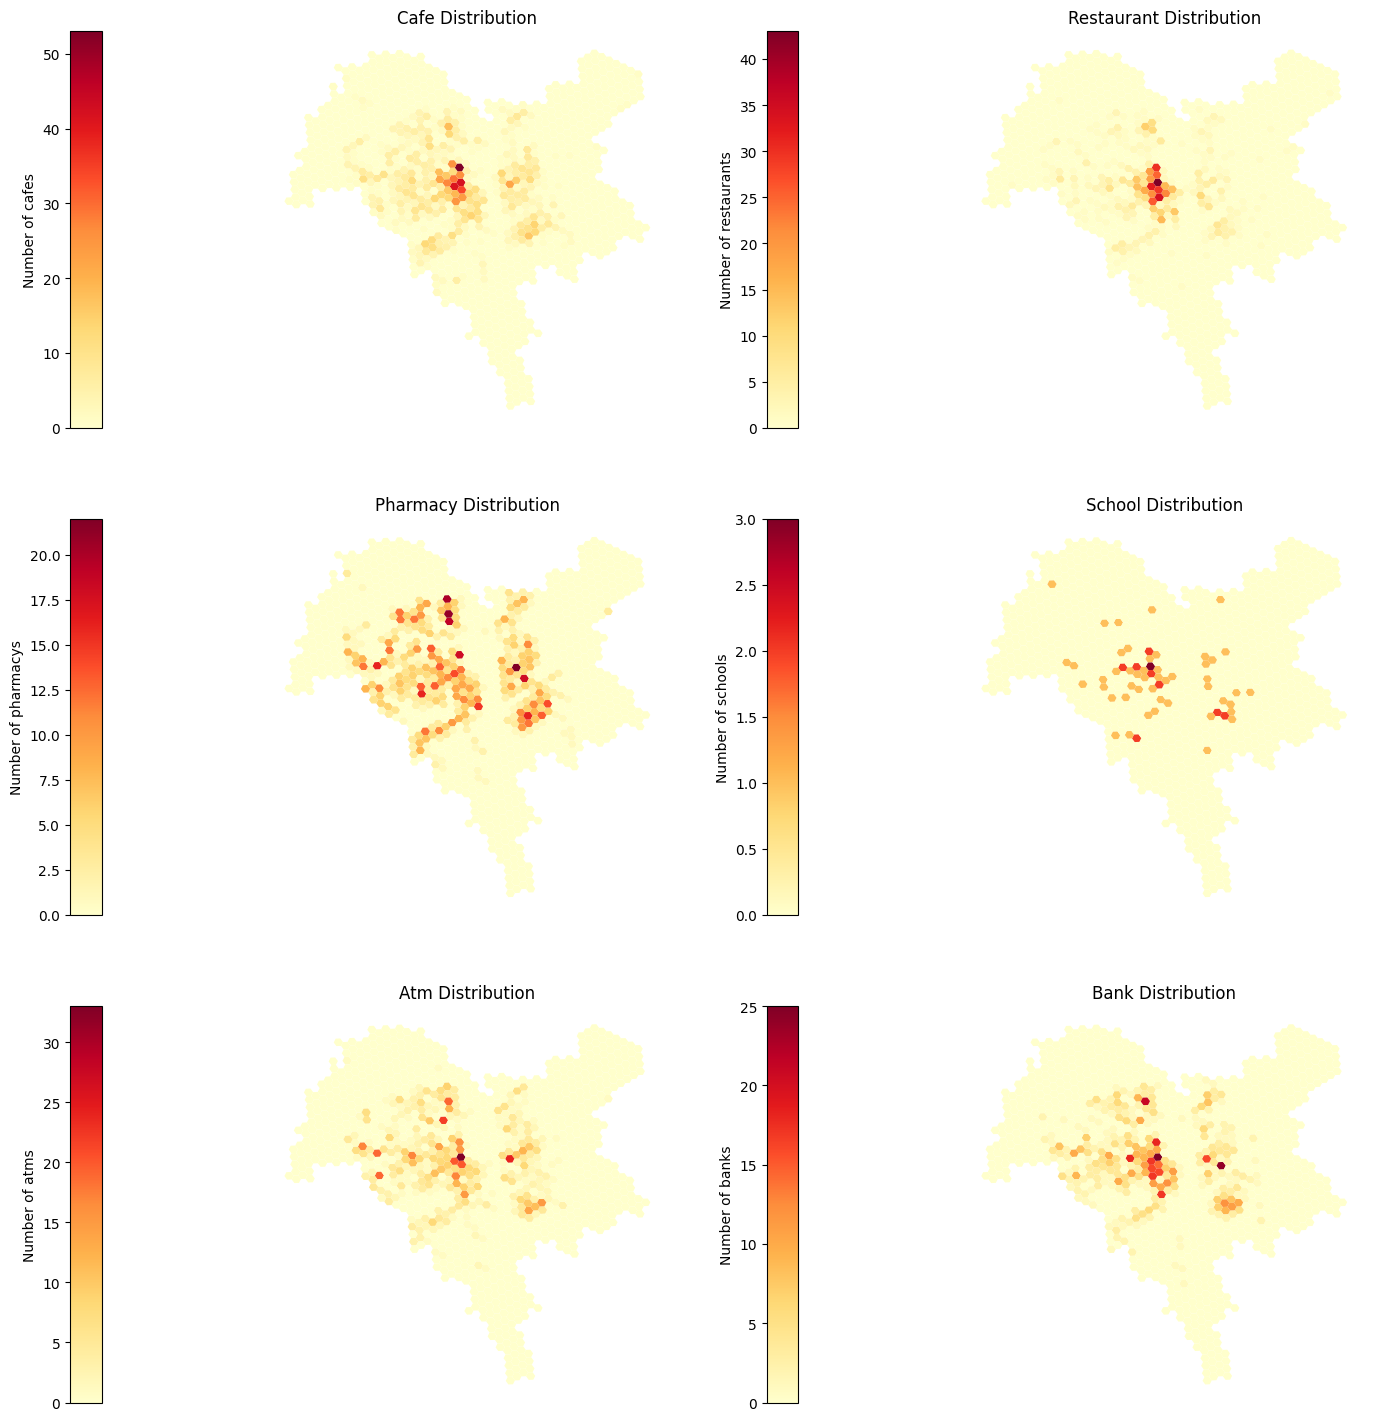

In [31]:
plot_amenity_distributions(
    result_gdf,
    amenity_types,
    figsize=(15, 15),
    ncols=2
)
plt.show()

In [32]:
def get_chain_counts_series(hexagon_gdf, name_variants, chain_name, amenity_types=None, verbose=False):
    """
    Get counts of specific  chain as a Series indexed by hexagon index,
    handling different name variations and amenity types
    
    Parameters:
    -----------
    hexagon_gdf : GeoDataFrame
        GeoDataFrame containing hexagon polygons
    name_variants : list
        List of name variations to match (e.g., ['АТБ-Маркет', 'АТБ-маркет', 'АТБ'])
    chain_name : str
        Name to use for the resulting count column (e.g., 'atb')
    amenity_types : list, optional
        List of amenity/shop types to filter by (e.g., ['shop', 'supermarket'])
        If None, will count all matches regardless of type
    
    Returns:
    --------
    pandas.Series: Counts of chain stores per hexagon
    """
    hexagon_gdf['wkt'] = hexagon_gdf.geometry.apply(lambda x: x.wkt)
    
    # Create the ILIKE conditions for name matching
    name_conditions = " OR ".join([f"name ILIKE '{name}'" for name in name_variants])
    
    # Add amenity type filter if specified
    type_filter = ""
    if amenity_types:
        type_conditions = " OR ".join([
            f"amenity = '{t}' OR shop = '{t}'" 
            for t in amenity_types
        ])
        type_filter = f"AND ({type_conditions})"
    
    query = f"""
    WITH hexagons AS (
        SELECT 
            cell,
            ST_Transform(ST_GeomFromText(wkt, 4326), 3857) as geom
        FROM (
            SELECT unnest(ARRAY{hexagon_gdf['cell'].tolist()}) as cell,
                   unnest(ARRAY{hexagon_gdf['wkt'].tolist()}) as wkt
        ) t
    )
    SELECT 
        h.cell,
        COUNT(p.*) as store_count,
        string_agg(DISTINCT p.name, ', ') as matched_names
    FROM hexagons h
    LEFT JOIN planet_osm_point p ON ST_Contains(h.geom, p.way)
    WHERE ({name_conditions})
    {type_filter}
    GROUP BY h.cell
    ORDER BY h.cell;
    """
    
    result_df = pd.read_sql_query(query, engine)
    
    # Debug info
    if verbose:
        print(f"\nMatched names for {chain_name}:")

    all_matches = set()
    for names in result_df['matched_names'].dropna():
        all_matches.update([n.strip() for n in names.split(',')])
        
    if verbose:
        for name in sorted(all_matches):
            print(f"- {name}")
    
    # Create the series with zeros
    result_series = pd.Series(0, index=hexagon_gdf.index, name=f'{chain_name}_count')
    
    # Map cell values to indices and update counts
    cell_to_idx = dict(zip(hexagon_gdf['cell'], hexagon_gdf.index))
    for _, row in result_df.iterrows():
        if row['cell'] in cell_to_idx:
            idx = cell_to_idx[row['cell']]
            result_series[idx] = row['store_count']
    
    return result_series


def write_aggregated_chain_count_to_gdf(gdf, amenity_types, chain_variants, chain_name, verbose=False):
    """
    Add chain store counts to GeoDataFrame using specified name variants
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame to add the counts to
    amenity_types : list
        List of amenity/shop types to filter by (e.g., ['shop', 'supermarket'])
    chain_variants : list
        List of name variations to match (e.g., ['АТБ-Маркет', 'АТБ'])
    chain_name : str
        Name to use for the column (will be appended with '_count')
    verbose : bool, optional
        Whether to print summary statistics
    """
    # Get counts
    chain_counts = get_chain_counts_series(
        gdf,
        name_variants=chain_variants,
        chain_name=chain_name,
        amenity_types=amenity_types,
        verbose=verbose
    )
    
    # Add to GeoDataFrame
    db_column_name = f'{chain_name.lower()}_count'
    gdf[db_column_name] = chain_counts
    
    print(f"Total {chain_name} stores: {gdf[db_column_name].sum()}")

    if verbose:
        print(f"\n{chain_name} store summary:")
        print(f"Hexagons with {chain_name}: {len(gdf[gdf[db_column_name] > 0])}")
        print(f"\nTop 5 hexagons by {chain_name} count:")
        print(gdf[gdf[db_column_name] > 0][db_column_name].sort_values(ascending=False).head())

In [ ]:
write_aggregated_chain_count_to_gdf(result_gdf, ['shop', 'supermarket'], ['АТБ-Маркет', 'АТБ'], 'atb')
write_aggregated_chain_count_to_gdf(result_gdf, ['shop', 'supermarket'], ['Novus', 'Новус'], 'novus')
write_aggregated_chain_count_to_gdf(result_gdf, ['shop', 'supermarket'], ['ЕКО маркет','ЕКО-маркет'], 'eko_market')



In [ ]:
from sqlalchemy import text

def write_gdf_to_postgis(gdf, table_name):
    """
    Write a GeoDataFrame to PostGIS
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        The GeoDataFrame to write
    table_name : str
        Name for the table in PostGIS
    """
    # Ensure geometry is in EPSG:4326
    gdf = gdf.copy()
    
    # Remove 'wkt' column if it exists
    if 'wkt' in gdf.columns:
        gdf = gdf.drop('wkt', axis=1)
    
    if gdf.crs is None:
        print("Warning: CRS was not set. Assuming EPSG:4326")
        gdf.set_crs(epsg=4326, inplace=True)
    elif gdf.crs != 'EPSG:4326':
        gdf = gdf.to_crs(epsg=4326)
    
    try:
        # Convert geometry to WKB format
        gdf['geom'] = gdf['geometry'].apply(lambda x: x.wkb)
        gdf.drop('geometry', axis=1, inplace=True)
        
        # Create PostGIS table
        create_table_query = text(f"""
        DROP TABLE IF EXISTS {table_name};
        CREATE TABLE {table_name} (
            id SERIAL PRIMARY KEY,
            cell VARCHAR(255),
            {', '.join(f"{col} FLOAT" for col in gdf.columns if col not in ['cell', 'geom'])},
            geom geometry(Polygon, 4326)
        );
        CREATE INDEX {table_name}_geom_idx ON {table_name} USING GIST (geom);
        """)
        
        with engine.begin() as connection:
            # Create table
            connection.execute(create_table_query)
            print(f"Created table {table_name}")
            
            # Prepare data for insertion
            for _, row in gdf.iterrows():
                insert_query = text(f"""
                INSERT INTO {table_name} (cell, {', '.join(col for col in row.index if col not in ['cell', 'geom'])}, geom)
                VALUES (
                    :cell,
                    {', '.join([f':{col}' for col in row.index if col not in ['cell', 'geom']])},
                    ST_SetSRID(ST_GeomFromWKB(:geom), 4326)
                );
                """)
                
                # Prepare values dict
                values = {'cell': row['cell'], 'geom': bytes(row['geom'])}
                values.update({
                    col: row[col] 
                    for col in row.index 
                    if col not in ['cell', 'geom']
                })
                
                connection.execute(insert_query, values)
            
            print(f"Inserted {len(gdf)} rows into {table_name}")
            
    except Exception as e:
        print(f"Error: {str(e)}")
        raise

In [ ]:
table_name = 'osm_loc_alike_kyiv'
write_gdf_to_postgis(result_gdf, table_name)


Created table osm_loc_alike_kyiv
Inserted 1182 rows into osm_loc_alike_kyiv


In [ ]:
def read_postgis_to_gdf(table_name, engine):
    """Read PostGIS table back into a GeoDataFrame"""
    query = f"""
    SELECT 
        *,
        ST_AsText(geom) as geometry
    FROM {table_name};
    """
    df = pd.read_sql_query(query, engine)
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
    gdf.drop('geom', axis=1, inplace=True)
    return gdf

# Read back
from shapely import wkt
gdf_from_db = read_postgis_to_gdf(table_name, engine)

In [ ]:
gdf_from_db = read_postgis_to_gdf(table_name, engine)
gdf_from_db


,id,cell,cafe_count,restaurant_count,pharmacy_count,school_count,atm_count,bank_count,atb_count,novus_count,eko_market_count,geometry
0,1,881e638717fffff,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"POLYGON ((30.39326 50.51495, 30.3901 50.51096,..."
1,2,881e63b067fffff,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,"POLYGON ((30.64893 50.47488, 30.64576 50.47089..."
2,3,881e63babbfffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((30.64046 50.38095, 30.63729 50.37696..."
3,4,881e6384a9fffff,12.0,19.0,4.0,1.0,4.0,6.0,0.0,1.0,0.0,"POLYGON ((30.50273 50.46718, 30.49956 50.46319..."
4,5,881e63a309fffff,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,"POLYGON ((30.69742 50.37849, 30.69425 50.3745,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1177,1178,881e63b255fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((30.68356 50.54594, 30.68038 50.54197..."
1178,1179,881e614d55fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((30.75858 50.57506, 30.7554 50.57109,..."
1179,1180,881e63b11dfffff,4.0,1.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,"POLYGON ((30.62988 50.45098, 30.62671 50.44699..."
1180,1181,881e63b1b9fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((30.70344 50.4138, 30.70027 50.40981,..."


TODO:
- filter out aurora stores from shops count
- add city boundaries?
- add more features
- do the same transformations for Lviv
- run ML algorithms to infer locations in Lviv